# Transformer model Architecture

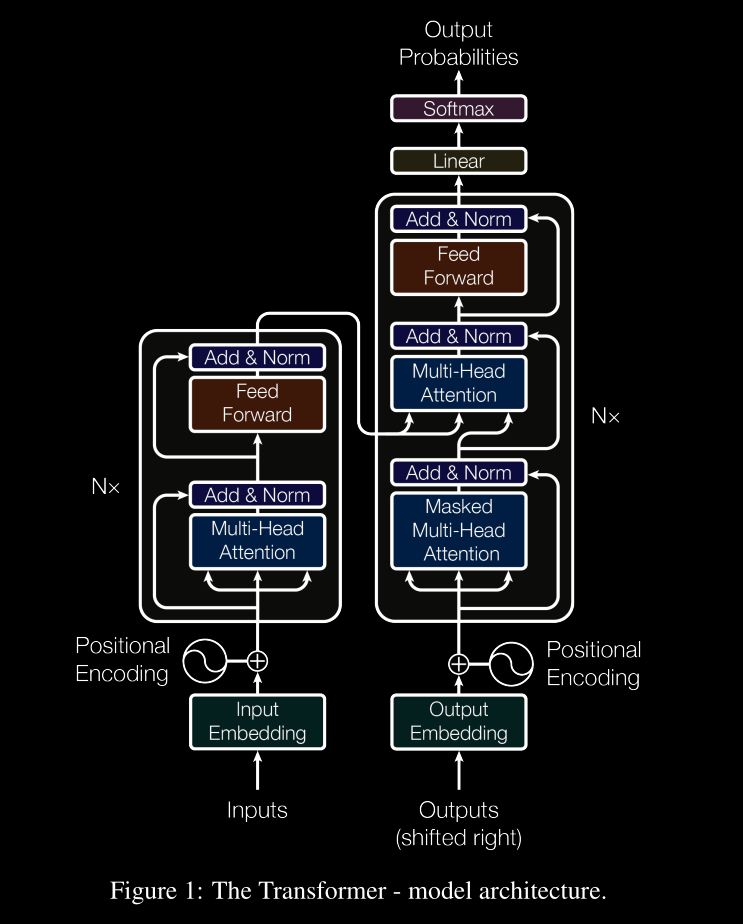

# Encoder-Decoder Stacks:

**Encoder:** Each layer of encoder has two sub-layers. The first is multi-head attention mechanism second is position wise fully connected feed-forward network. A residual connection around each of the two sub-layers is applied followed by layer normalization. To facilite the residual connections all the sub-layers as well as embedding produce outputs of dimensions d_model = 512

**Decoder:** The decoder has three sub-layers. Two similar to the encoder layer while third sub-layers performs multi-head attention all over the outputs. Residual connection followed by layer normalization is also applied.

# Important import statements

In [ ]:
import torch
import torch.nn as nn
import math
"""
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
rom tokenizers.trainers import WordLevelTrainer
rom tokenizers.pre_tokenizers import Whitespace

try:
    import torchmetrics
    import torchmetrics.text
except ImportError:
    print("Warning: torchmetrics not installed or [text] extra not found. Evaluation metrics will be skipped.")
    torchmetrics = None

"""

# InputEmbedding

First we are going to be building an InputEmbedding.

InputEmbedding: Allows to convert the  original sentence into a vector of 512 dimensions. First the sentences are converted into a list of input ids--> Input Ids are numbers that corresponds to the position of each words inside the english dictionary--> Each of these ids then corresponds to a vector of size 512

In [ ]:
class InputEmbeddings(nn.Module):

  def __init__(self, d_model: int, vocab_size: int): # In the constructor where we will first tell them what is the dimension of the model. And then we will tell them the size of our input vocabulary.
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size,d_model) #Embedding(num_embeddings, embedding_dim), num_embedding = total number of unique items, embedding_dim = size of each input vector

  def forward(self,x):
    return self.embedding(x)*math.sqrt(self.d_model) # purpose of embedding is to link the Input Ids to the corresponding vector. The vector is learnt by the model.


In [ ]:
"""
embedding = nn.Embedding(num_embeddings = 10,embedding_dim = 3)
input = torch.tensor([1,2,4,5])
output = embedding(input)
print(output)
"""

Workings of nn.Embedding:
It creates a matrix of shape(10,3) Initialized randomly. Each Row corresponds to a vector of specific index. The vector is learnt by the model

# Positional Encoding
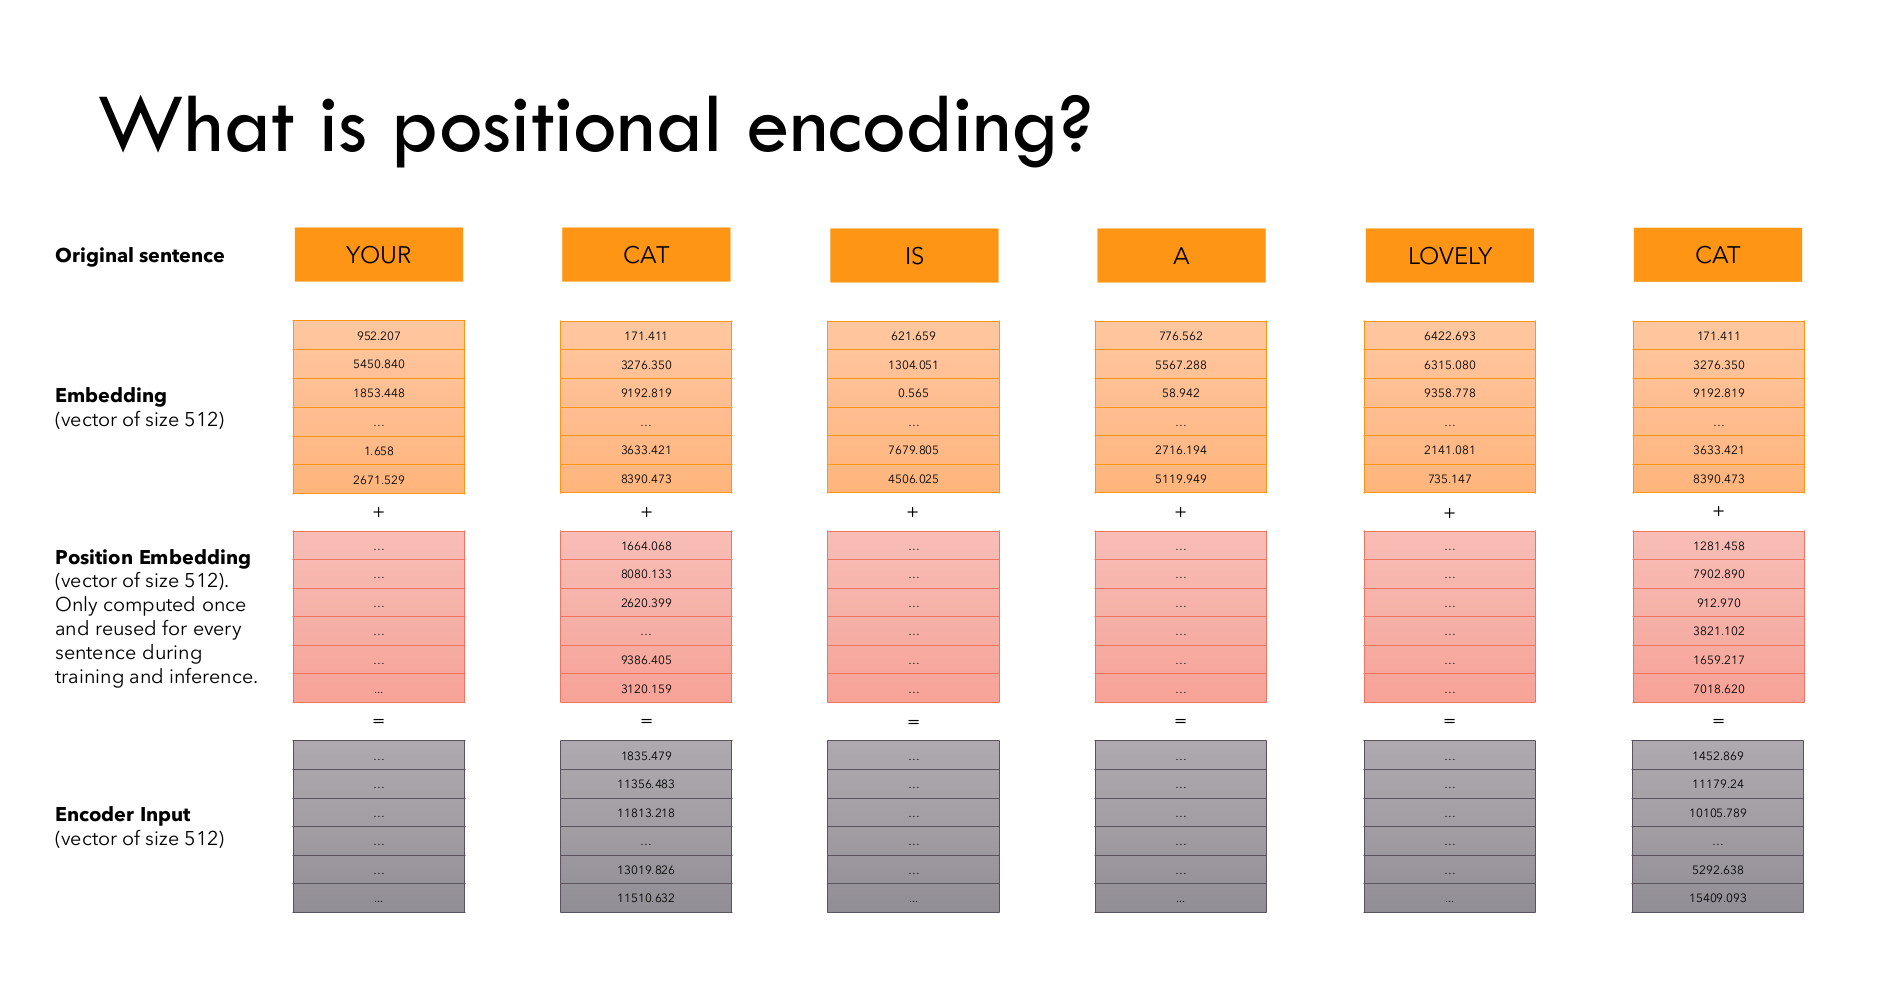
Now we want to convey the position of each word in a sentence in order to make the model make use of order of sequence. This is done by adding another vector of the same size as the embedding of 512 That includes some special values given by the formula:

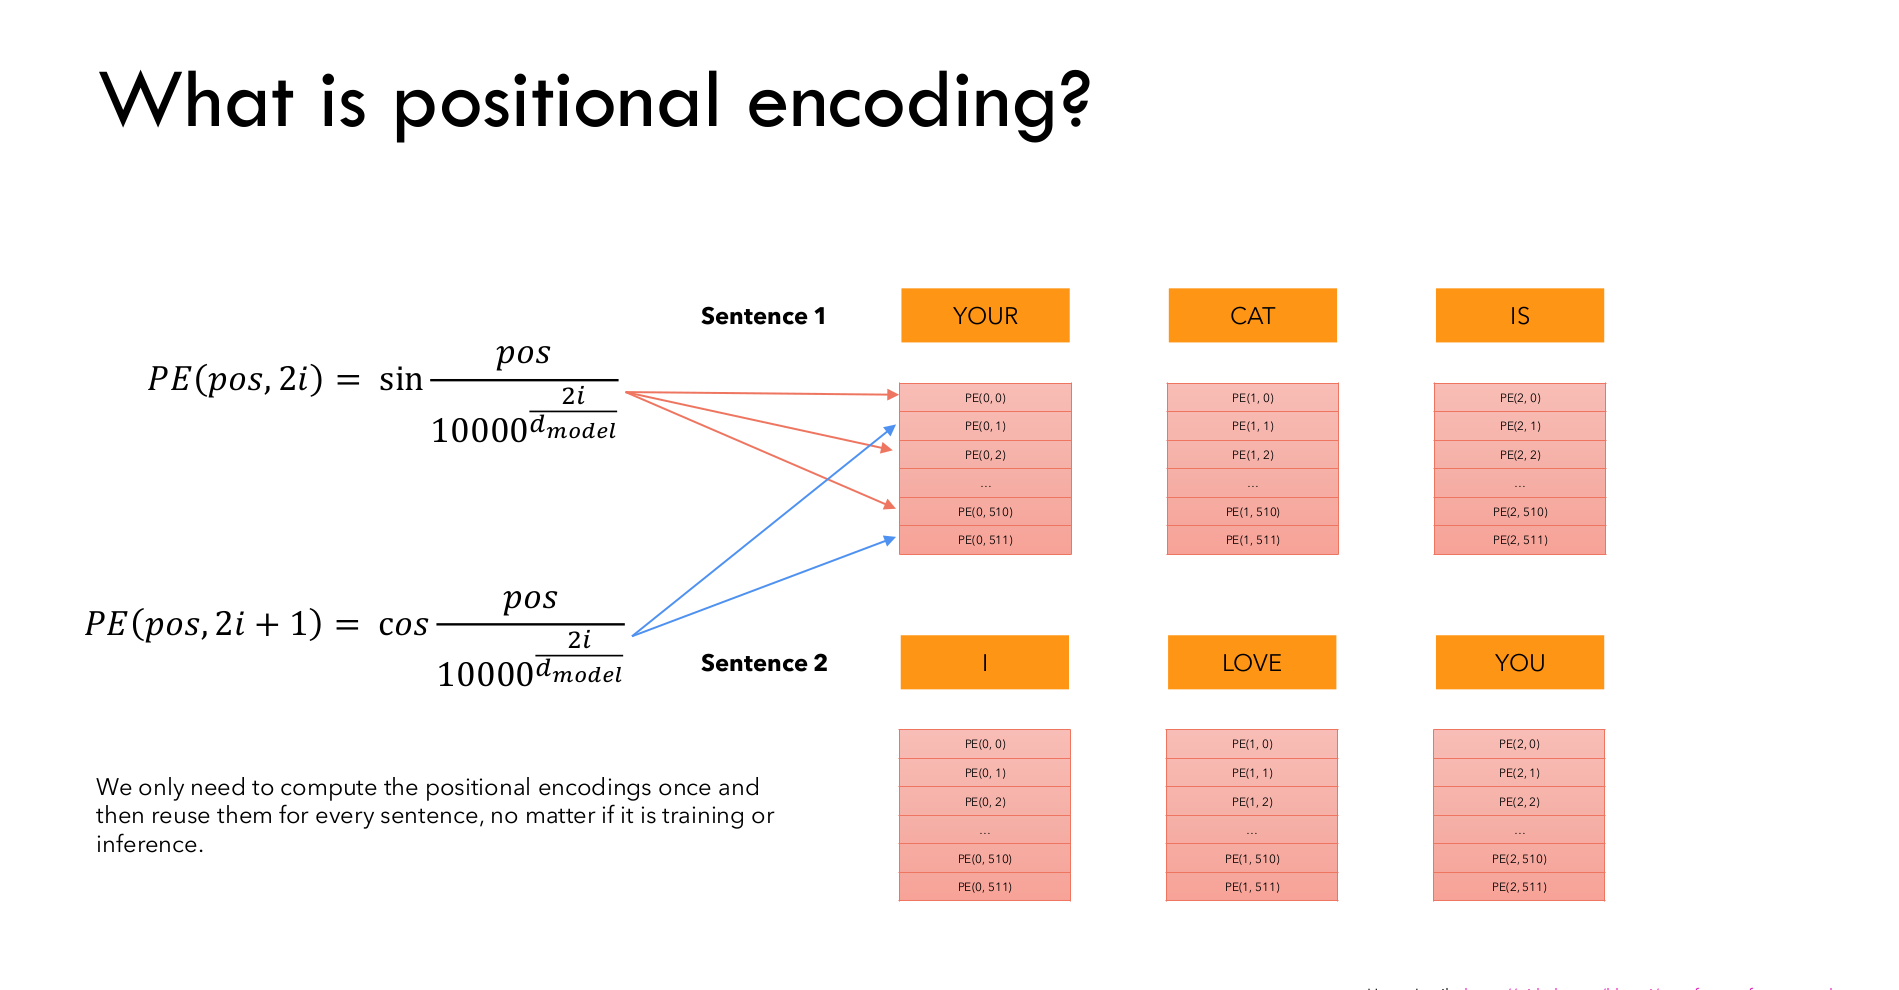

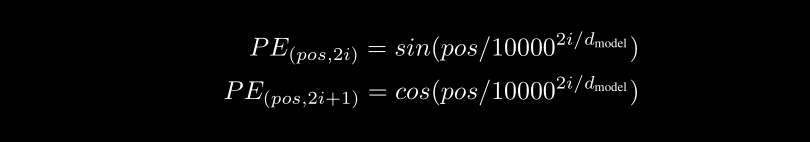

In the even position of the vector we apply the first formula and in the odd position of the vector we apply the second formula

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        self.register_buffer('pe', pe)
        """
         nn.Module.register_buffer():
         arguments are not listed in the list of parameters returned by module.Parameters() and not updated by optimizers durinig trining
        """

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        """
        requires_grad_(requires_grad = False): Useful in case of transfer learning where parameters must be freezed and not be recoded while calculating gradient discent during backprobagation.
        if require_grad = True: parameters will be recoded and updated during backward propagation.
        """
        return self.dropout(x)


# Add and Normalization
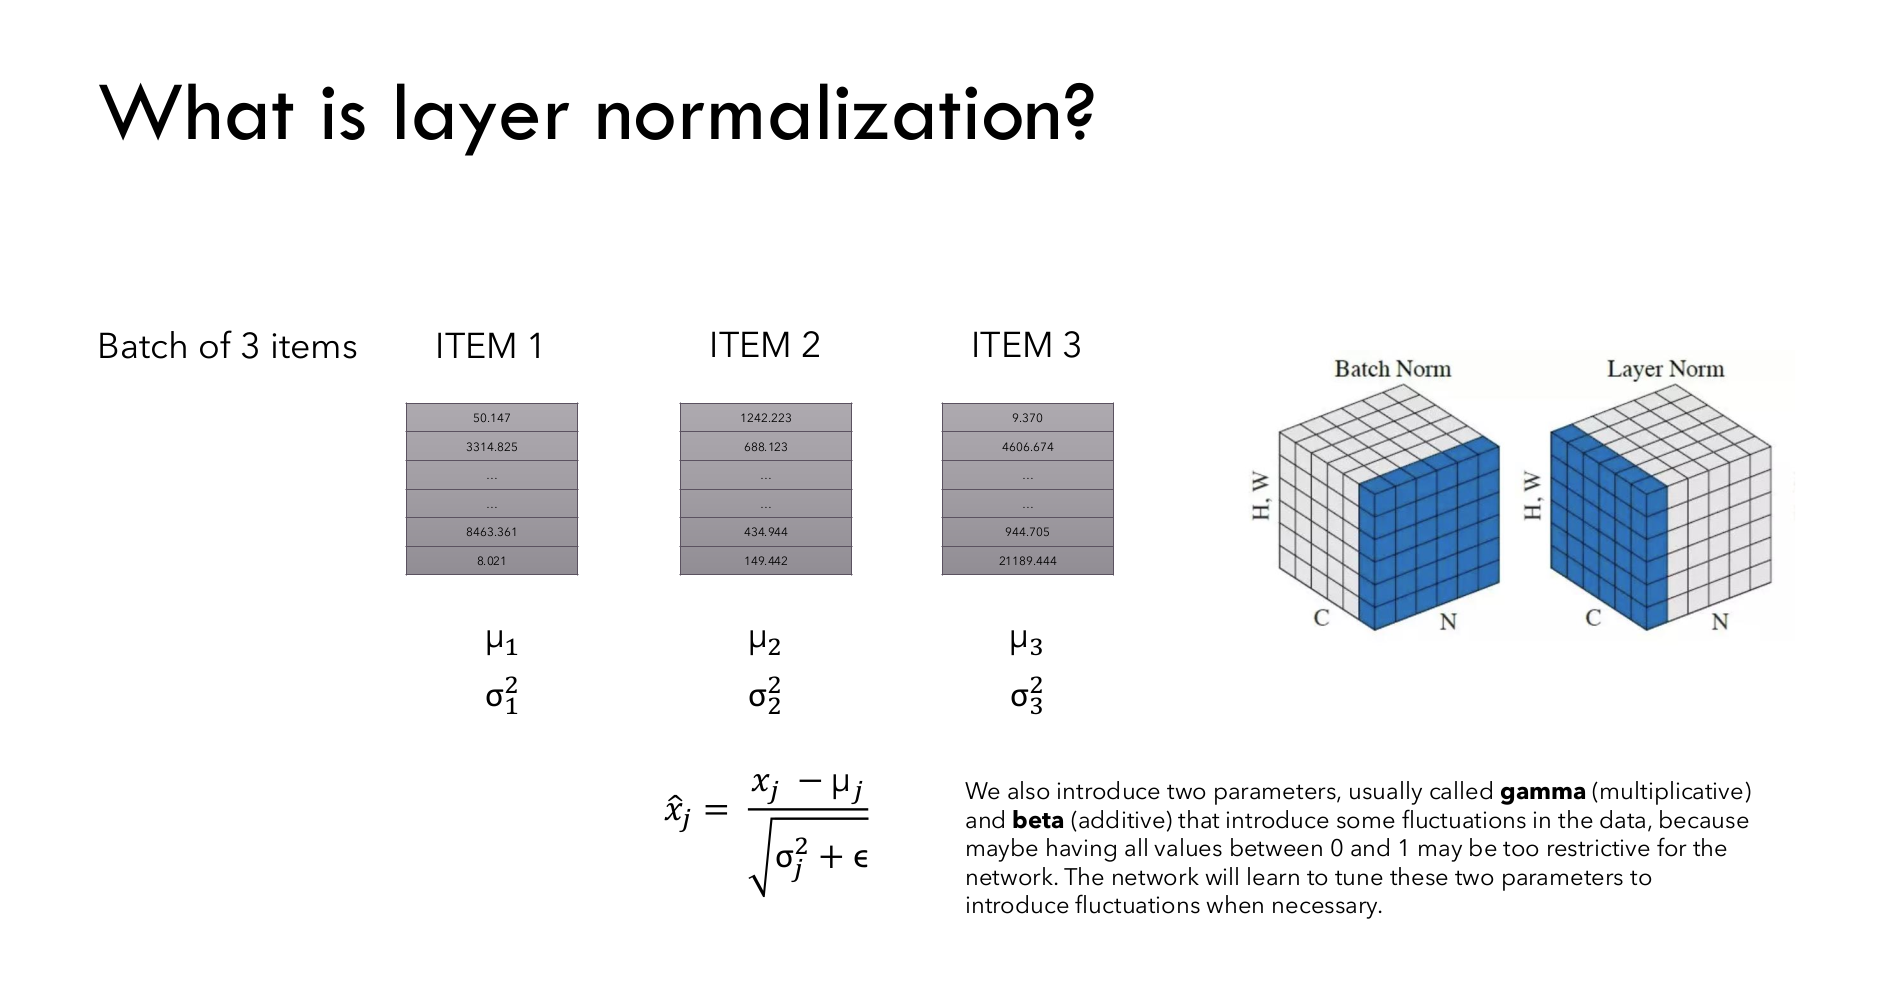
**Layer-normalization**: if you have a batch of 'n' items with each item having it own features. Layer normalization means that for eatch items in the batch we calculate mean and variance independent of other items in the batch.



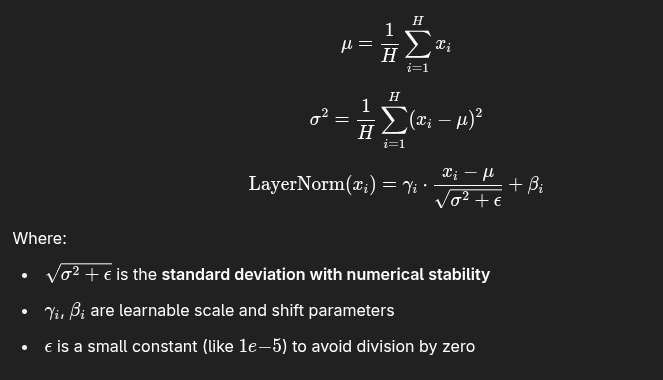

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias


# Feed Forward Network


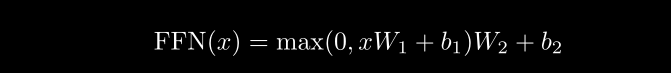

In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


# Multi-Head Attention
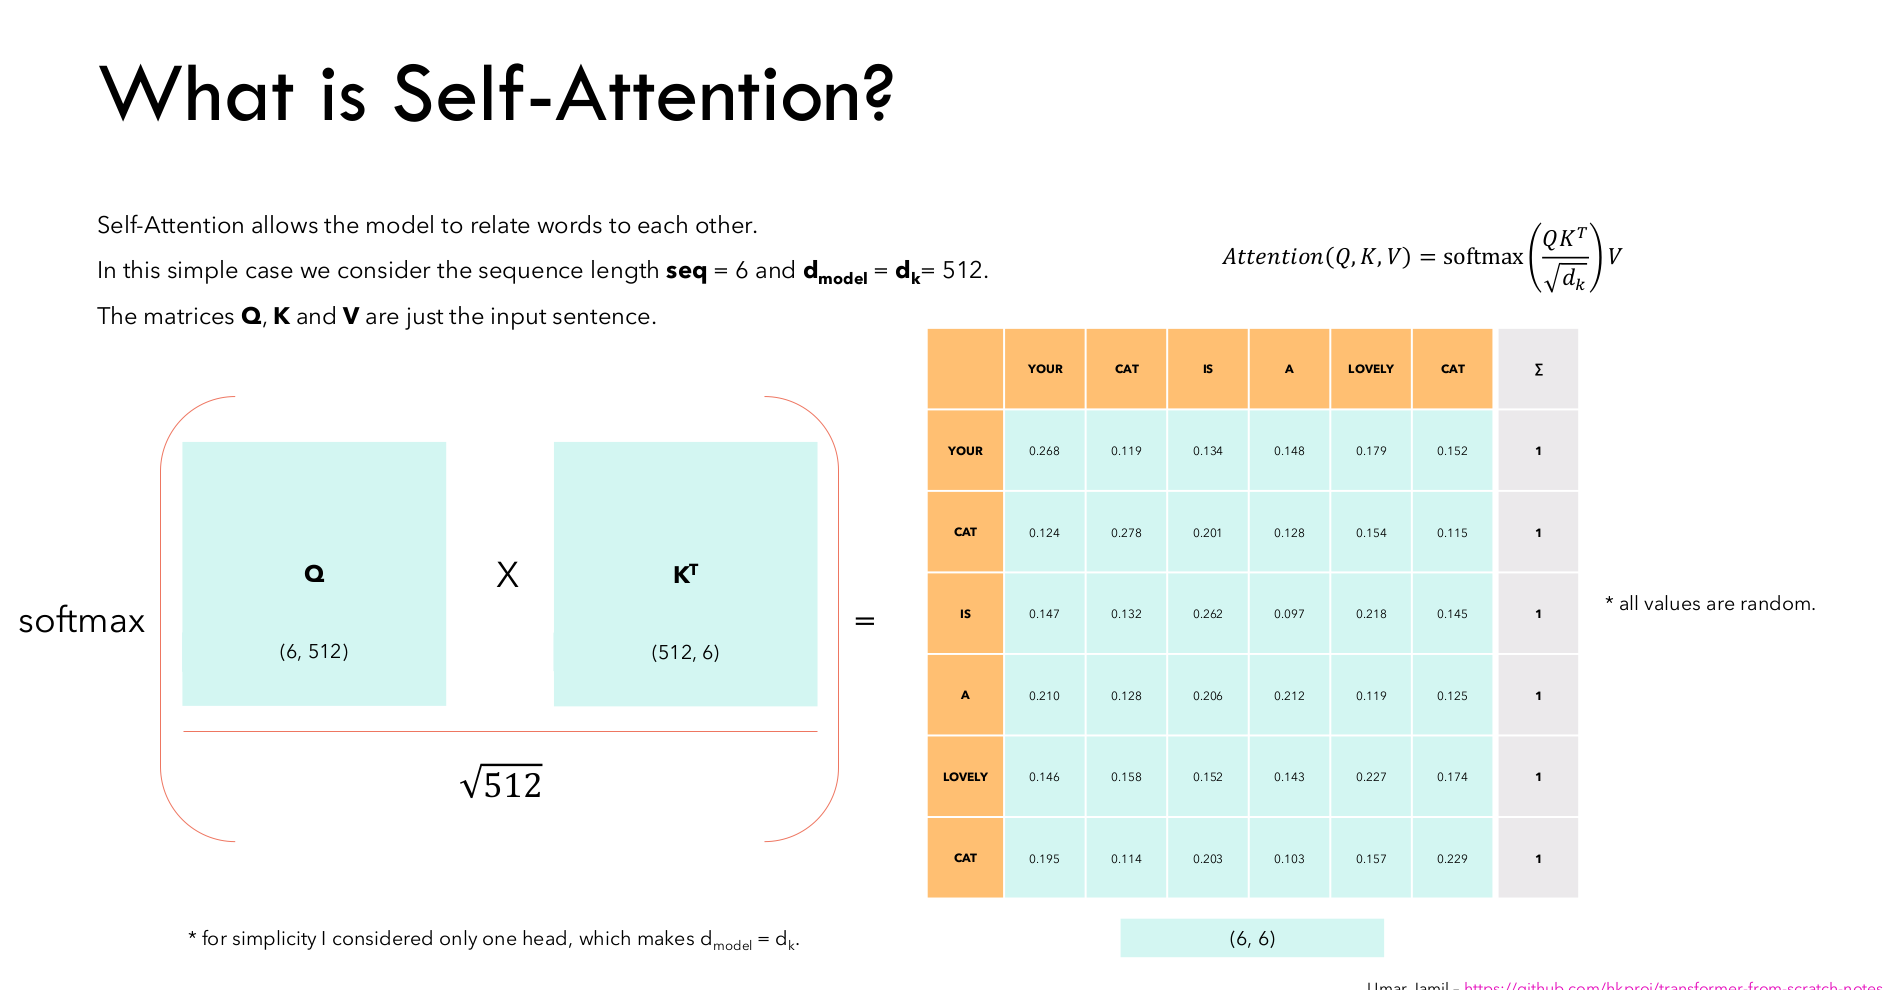

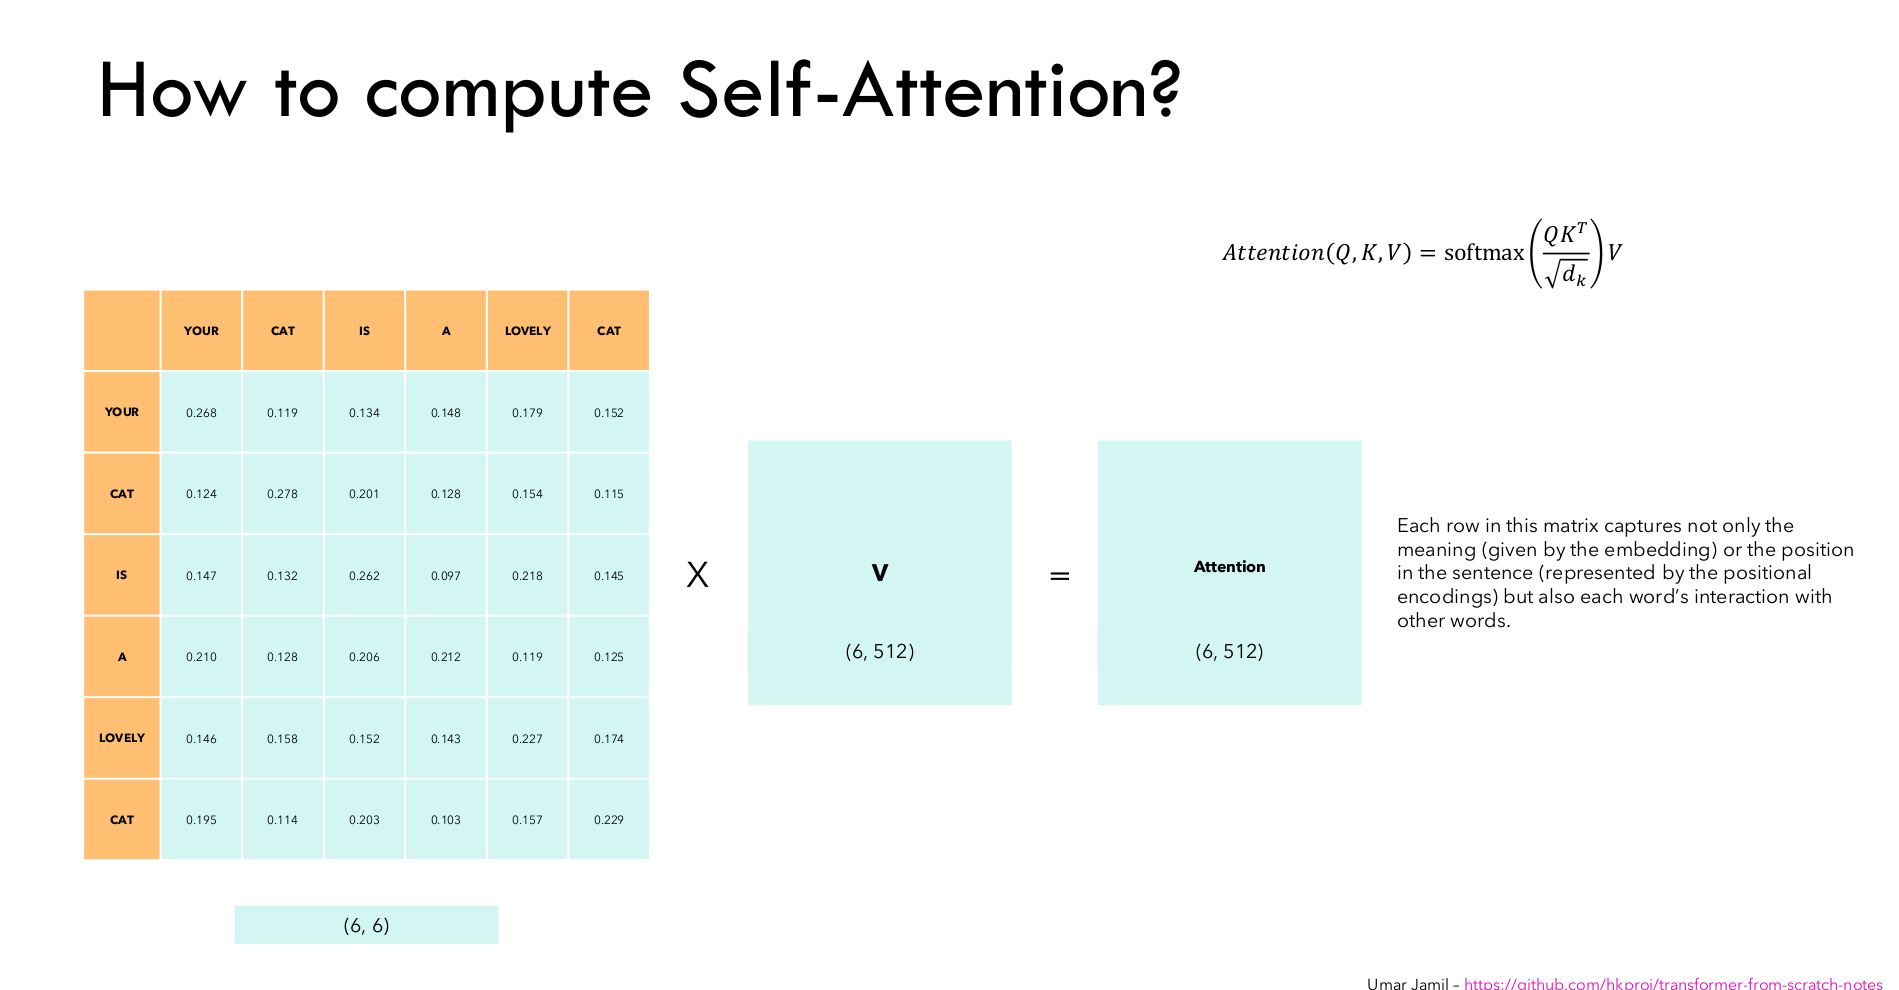
Through this we are bale to calculate not only the meaning of the words or the position in the sequence but also the interaction of the words with other words.
Properties of self-attention:
- Self attention is permutation invariant
- Self attention requires no parameters. Up until now the interaction between words has been driven by their positional encoding and and their embedding
- Values along the diagonal is the highest because its the dot product of each word with itself

We now take the input($seq$, $d$<sub>model</sub>) and make 4 copies of the input  one is sent to the skip connection and the other 3 is sent into the ***multi-head attention*** model. The same input becomes the Query($Q$), Key($K$) and Value($V$) all with dimension ($seq$,$d$<sub>model</sub>) all these three matrices are then multiplied with three different parameter matrices $W^Q$, $W^K$, $W^V$ all with dimension ($d$<sub>model</sub>, $d$<sub>model</sub>)

$\begin{pmatrix}Q&K&V\end{pmatrix}$ $\cdot$ $\begin{pmatrix}W^Q\cr W^K\cr W^V\cr\end{pmatrix} =$ $\begin{pmatrix}Q'\cr K'\cr V'\cr\end{pmatrix}$

The $Q', K', V'$ are then split into smaller matrices by the $d$<sub>model</sub> dimension

Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.


What is Multi-Head Attention: Instead of Just one "Attention Focus", it has multiple heads that can focus on different aspects of the input simultaneously. Each "head" learns to pay attention to different kinds of relationships, making the model more robust and capable of capturing richer information.

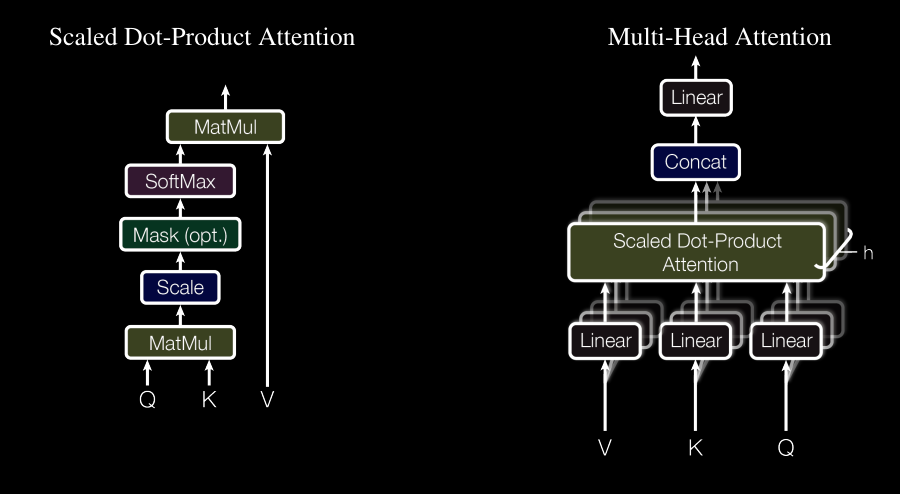

Workings: We have our inpute sequence which is ($seq$, $d$<sub>model</sub>) --> Transformed into three matrices which are Q, K, V which are multiplued by matrices called $W^Q, W^K, W^V$ respectively which results in three matrices Q', K', V' respectively

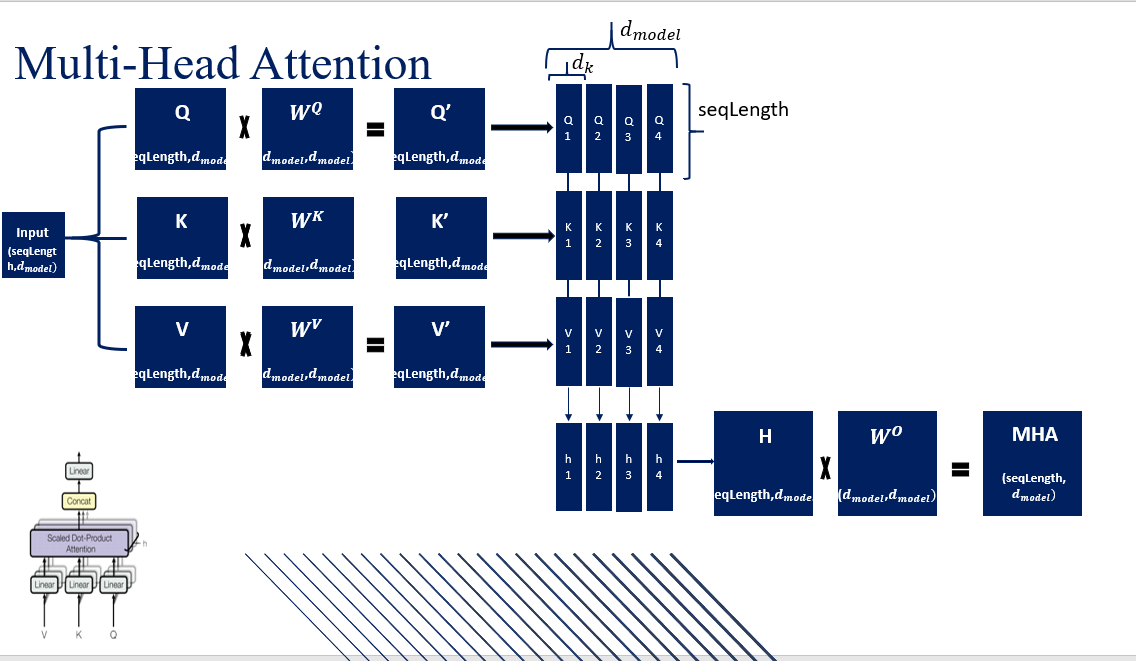

All the Atention head produce their outputs using the above formula to

$(Q1,K1,V1) --> h1$

$(Q2,K2,V2) --> h2$

$(Q3,K3,V3) --> h3$

$(Q4,K4,V4) --> h4$

Each head is watching the full sentence but a different aspect of the embedding of each word. We do this to make sure that each head learns different aspect of the same word

What are $Q, K, V:$

Query (Q): Each word serves as a query to compute the attention scores.

Q: what I am looking for.


Key (K): Each word acts as a key to determine its relevance to other words.

K: what I can offer.


Value (V): Each word contributes as a value to the attention-weighted sum.

what I actually offer.

By comparing Q and K we figure out how relevant the other word is to the current word

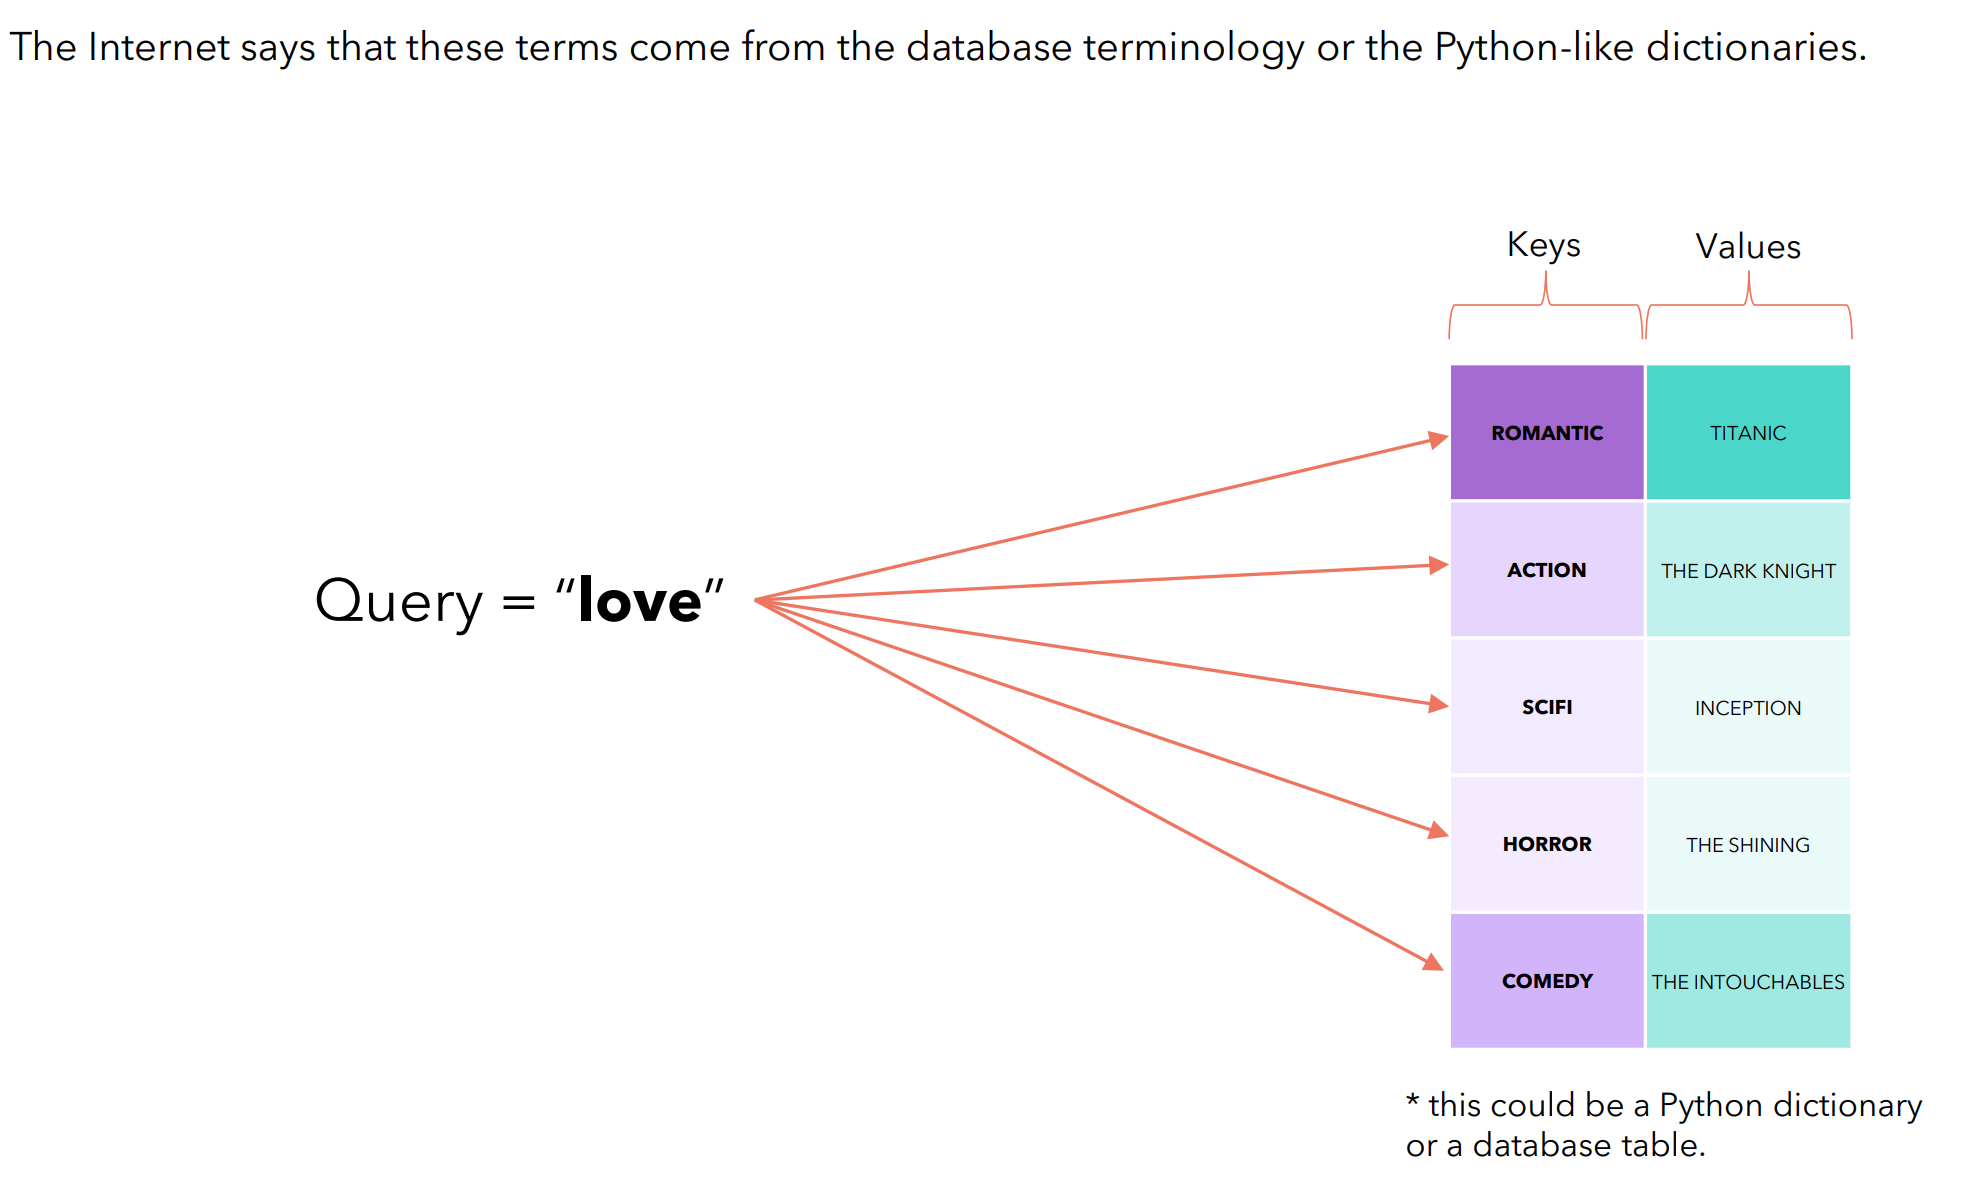





The $Q', K', V'$ matrices are each split into "h" heads.

Why split? Each head can learn to attend to different parts of the input sequence or different relationships. For instance, one head might focus on grammatical relationships, another on semantic similarity, and so on. This allows the model to capture diverse dependencies.
For visulization we use example from the paper: The word $making$ is related to $difficult$ and $more$ by different attention heads because the attention head focusing on parts of the $making$ embedding could see the relation between $making$ and $difficult$ that other attention head could not se. Similarly some attention head could establish relation between $making$ and $more$ as they were exposed to the part of embedding allowing them to from that relation


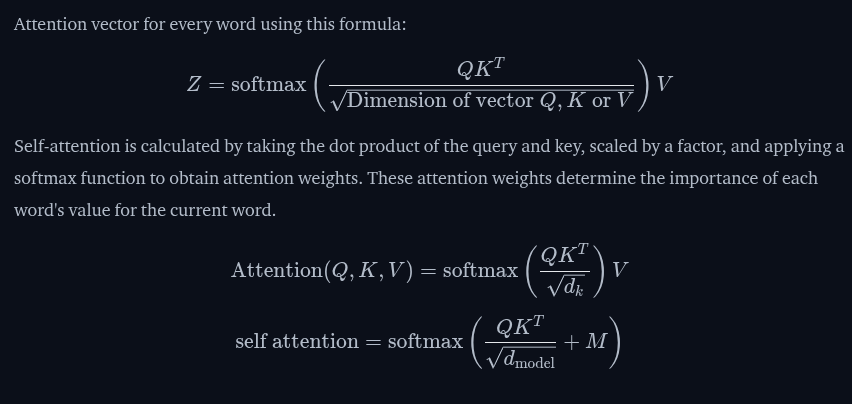

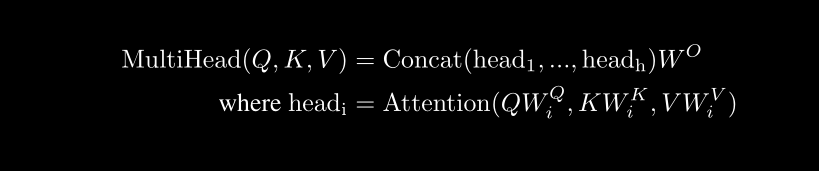

The produced outputs are then concatinated using the above formula into a matrix of H with dimension (seq_len, h*d_model)

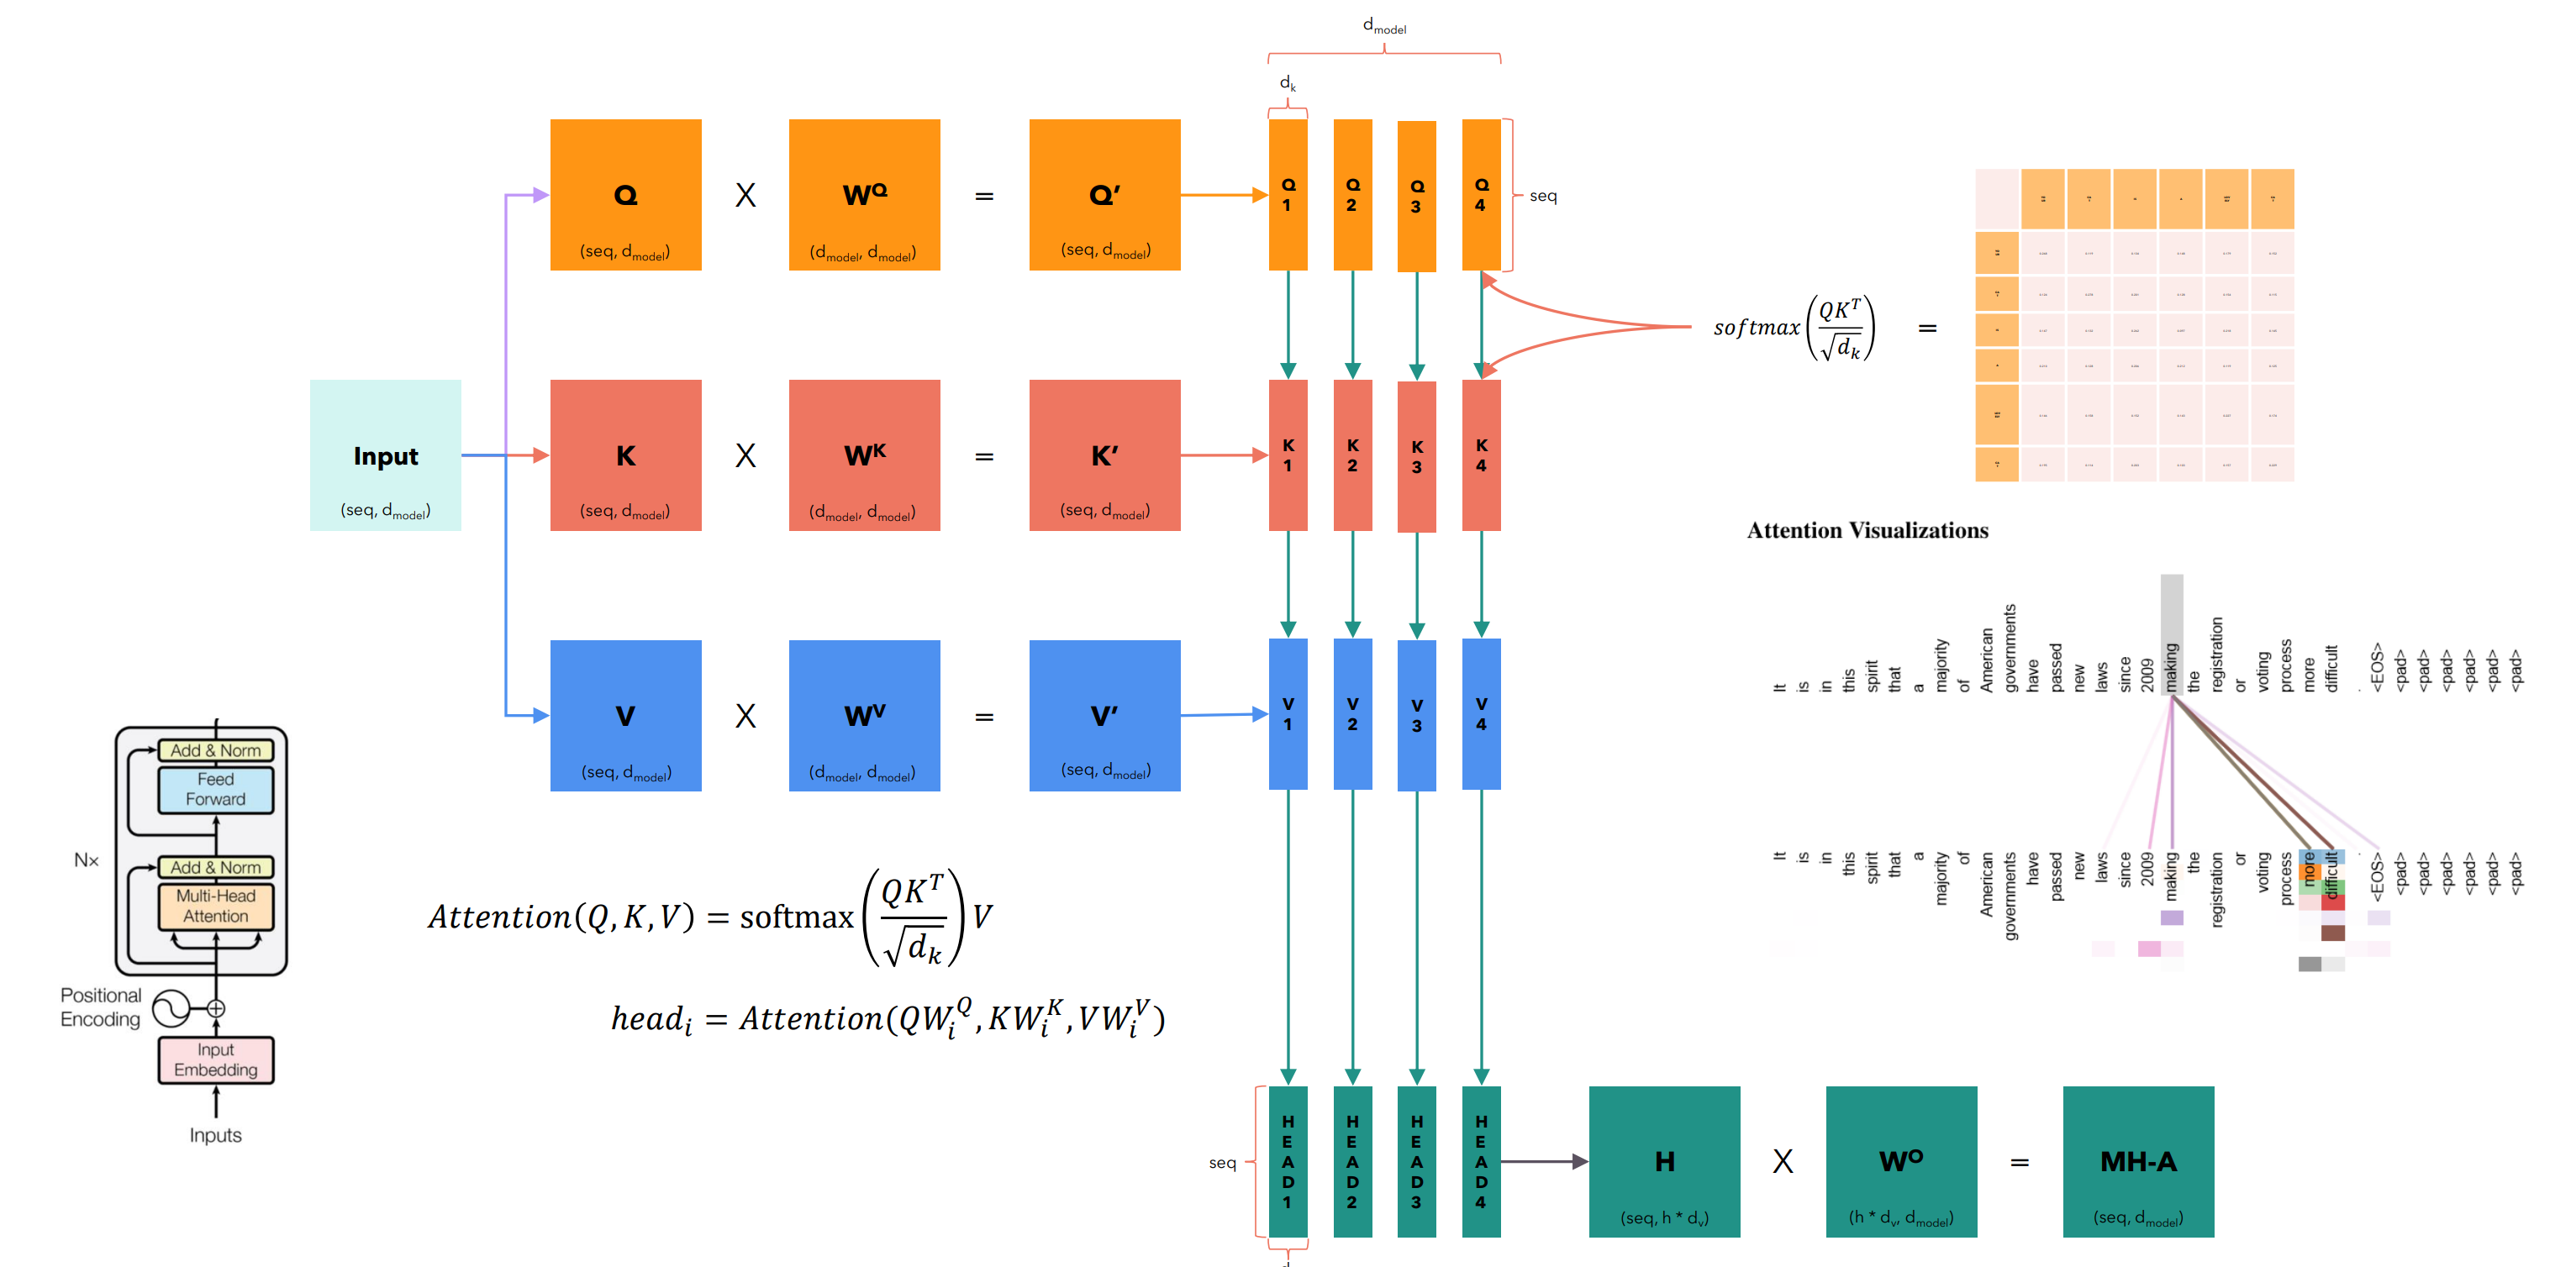

### Masked Multihead Attention:
Our goal is to make model casual: It means that the output at certain position can only depend on the words on previous position. The model must not be able to see future words

They way we do that is by replace the output of $(\frac{QK^T}{\sqrt{d~model~}})$ with -∞ before applying softmax so that softmax replaces the value with 0  

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int,dropout: float) ->None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    self.dropout = nn.Dropout(dropout)

    assert d_model%h == 0, "d_model is not divisible by h"

    self.d_k = d_model//h

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    self.w_o = nn.Linear(d_model, d_model)
  @staticmethod
  def attention(query, key, value, mask, dropout: float):
    d_k  = query.shape[-1]

    attention_scores = (query @ key.transpose(-2,-1)) /math.sqrt(d_k)
    if mask is not None:
      attention_scores.masked_fill_(mask==0, -1e9)
    attention_scores = attention_scores.softmax(dim = -1) # (Batch,h,seq_len, seq_len)

    return (attention_scores@value), attention_scores


  def forward(self, q,k,v,mask):
    query = self.w_q(q)  # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
    key = self.w_k(k)    # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
    value = self.w_v(v)  # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)

    # (Batch, seq_len, d_model) --> (Batch, seq_len, h, d_k) --> (Batch, h, seq_len, d_k)
    query = query.view(query.shape[0], query.shape[1], self.h,self.d_k).transpose(1,2) # --> to split the embedding into h parts
    # tensor.transpose(self, dim1, dim2) --> dim1, dim2 are swapped.
    """
    torch.Tensor.view() returns a new tensor with the same data as the self tensor but of a different shape.
    The returned tensor shares the same data and must have the same number of elements, but may have a different size.
    For a tensor to be viewed, the new view size must be compatible with its original size and stride, i.e., each new view
    dimension must either be a subspace of an original dimension, or only span across original dimensions.
    """

    key = key.view(key.shape[0], key.shape[1], self.h,self.d_k).transpose(1,2)
    value = value.view(value.shape[0], value.shape[1], self.h,self.d_k).transpose(1,2)

    x = attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # (Batch, h, seq_len, d_k) --> (Batch, seq_len, h, d_k) --> (Batch, seq_len, d_model)
    x = x.transpose(1,2).contiguos().view(x.shape[0],-1, self.h*self.d_k)

    """
    A tensor is considered contiguous if its elements are stored in a sequential, unbroken block of memory, in the same order as its logical indexing.
    """

    return self.w_o(x)




# Residual Connection

In [ ]:
class ResidualConnection(nn.Module):
  def __init__(self,dropout: float) -> None:
    super.__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self,x,sublayer):
    return x+self.dropout(sublayer(self.norm(x)))

# Encoder Block

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock, dropout: float):
      super().__init__()
      self.self_attention_block = self_attention_block
      self.feed_forward_block = feed_forward_block
      self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self,x,src_mask): # src_mask is the mask applied to the input of the encoder. We do that because we don't want the padding of the words to interact with other words
    x = self.residual_connection[0](x, lambda x: self.self_attention_block(x,x,x,src_mask))
    x = self.residual_connection[1](x, self.feed_forward_block)
    return x

One encoder object can be made up of any number of encoder block.

In [ ]:
class Encoder(nn.Module):

  def __init__(self,layers: nn.ModuleList):
    super.__init__()
    self.layers = layers
    self.norm = LayerNormalization()
  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

# Decoder Block

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock, dropout: float ):
    super.__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connection = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
  def forward(self, x, encoder_output, src_mask, tgt_mask):
    """
    src_mask: mask applied to the encoder.
    tgt_mask: mask applied to the decoder.
    """
    x = self.residual_connection[0](x, lambda x: self.self_attention_block(x,x,x, tgt_mask))
    x = self.residual_connection[1](x, lambda x: self.self_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connection[2](x, self.feed_forward_block)
    return x


In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers: nn.ModuleList):
    super.__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

# Projecting Layer

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
    super.__init__()
    self.proj = nn.Linear(d_model, d_model)

  def forward(self,x):
    # (Batch, seq_len, d_model) --> (Batch, seq_len, Vocab_size)
    return torch.log_softmax(self.proj(x, dim = -1))


# Transformer Block

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder,src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer ):
    super.__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src, src_mask)

  def decode(self, encoder_output, src_mask,tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt,encoder_output,src_mask,tgt_mask)

  def project(self, x):
    return self.projection_layer(x)



In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int,d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff = 2048):

  # Create the embedding layers
  src_embedding = InputEmbeddings(d_model, src_vocab_size)
  tgt_embedding = InputEmbeddings(d_model, tgt_vocab_size)

  # Create the positional encoding layers
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  # Create Encoder Blocks
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block)

  # Create Decoder Block
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
    decoder_blocks.append(decoder_block)

  # Create Encoder and Decoder
  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_block))

  # Projection Layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  # Creating the Transformer
  transformer = Transformer(encoder, decoder, src_embedding, tgt_embedding, src_pos,tgt_pos, projection_layer)

  # Initialize the parameter
  for p in transformer.parameters():
    if p.dim()>1:
      nn.init.xavier_uniform_(p)

  return transformer


# Dataset

In [ ]:
from torch.utils.data import Dataset
class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()
        self.seq_len = seq_len

        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Transform the text into tokens
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Add sos, eos and padding to each sentence
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # We will add <s> and </s>
        # We will only add <s>, and </s> only on the label
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        # Make sure the number of padding tokens is not negative. If it is, the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too long")

        # Add <s> and </s> token
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only <s> token
        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Add only </s> token
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
            ],
            dim=0,
        )

        # Double check the size of the tensors to make sure they are all seq_len long
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # (seq_len)
            "decoder_input": decoder_input,  # (seq_len)
            "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(), # (1, 1, seq_len)
            "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).int() & causal_mask(decoder_input.size(0)), # (1, seq_len) & (1, seq_len, seq_len),
            "label": label,  # (seq_len)
            "src_text": src_text,
            "tgt_text": tgt_text,
        }

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

# Train

In [ ]:
from datasets import load_dataset
from tokenizers. models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path
import torchtext.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import warnings
from tqdm import tqdm
import os
from pathlib import Path


In [ ]:
from pathlib import Path

def get_config():
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

def get_weights_file_path(config, epoch: str):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}{epoch}.pt"
    return str(Path('.') / model_folder / model_filename)

# Find the latest weights file in the weights folder
def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))
    if len(weights_files) == 0:
        return None
    weights_files.sort()
    return str(weights_files[-1])

In [ ]:

# Huggingface datasets and tokenizers
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

import torchmetrics
from torch.utils.tensorboard import SummaryWriter

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)
    # Initialize the decoder input with the sos token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1) == max_len:
            break

        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next token
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat(
            [decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1
        )

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)


def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0

    source_texts = []
    expected = []
    predicted = []

    try:
        # get the console window width
        with os.popen('stty size', 'r') as console:
            _, console_width = console.read().split()
            console_width = int(console_width)
    except:
        # If we can't get the console width, use 80 as default
        console_width = 80

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device) # (b, seq_len)
            encoder_mask = batch["encoder_mask"].to(device) # (b, 1, 1, seq_len)

            # check that the batch size is 1
            assert encoder_input.size(
                0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            # Print the source, target and model output
            print_msg('-'*console_width)
            print_msg(f"{f'SOURCE: ':>12}{source_text}")
            print_msg(f"{f'TARGET: ':>12}{target_text}")
            print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

            if count == num_examples:
                print_msg('-'*console_width)
                break

    if writer:
        # Evaluate the character error rate
        # Compute the char error rate
        metric = torchmetrics.CharErrorRate()
        cer = metric(predicted, expected)
        writer.add_scalar('validation cer', cer, global_step)
        writer.flush()

        # Compute the word error rate
        metric = torchmetrics.WordErrorRate()
        wer = metric(predicted, expected)
        writer.add_scalar('validation wer', wer, global_step)
        writer.flush()

        # Compute the BLEU metric
        metric = torchmetrics.BLEUScore()
        bleu = metric(predicted, expected)
        writer.add_scalar('validation BLEU', bleu, global_step)
        writer.flush()

def get_all_sentences(ds, lang):
    for item in ds:
        yield item['translation'][lang]

def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    if not Path.exists(tokenizer_path):
        # Most code taken from: https://huggingface.co/docs/tokenizers/quicktour
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

def get_ds(config):
    # It only has the train split, so we divide it overselves
    ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train')

    # Build tokenizers
    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Keep 90% for training, 10% for validation
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in the source and target sentence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')


    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt

def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config["seq_len"], config['seq_len'], d_model=config['d_model'])
    return model

def train_model(config):
    # Define the device
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if (device == 'cuda'):
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
    elif (device == 'mps'):
        print(f"Device name: <mps>")
    device = torch.device(device)

    # Make sure the weights folder exists
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # If the user specified a model to preload before training, load it
    initial_epoch = 0
    global_step = 0
    preload = config['preload']
    model_filename = latest_weights_file_path(config) if preload == 'latest' else get_weights_file_path(config, preload) if preload else None
    if model_filename:
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']
    else:
        print('No model to preload, starting from scratch')

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device) # (b, seq_len)
            decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

            # Run the tensors through the encoder, decoder and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask) # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask) # (B, seq_len, d_model)
            proj_output = model.project(decoder_output) # (B, seq_len, vocab_size)

            # Compare the output with the label
            label = batch['label'].to(device) # (B, seq_len)

            # Compute the loss using a simple cross entropy
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Log the loss
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        # Run validation at the end of every epoch
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Save the model at the end of every epoch
        model_filename = get_weights_file_path(config, f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)